In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def transformation(Y):
    l=[]
    n = 0
    for y in Y:
        if y =='TLS':
            n = n+1
            l.append(1)
        else:
            l.append(0)
    print(n)
    return np.array(l)
def count(Y):
    n = 0
    for y in Y:
        if y ==1:
            n = n+1
    print(n)

### 1. load dataset

In [5]:
sample = ["c_4","c_3","c_36"]
X_list = []
y_list = []
Gene = []
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#load data
for i in range(len(sample)):
    #load Y
    path = 'result/'+sample[i]+'_annotation.csv'
    data = pd.read_csv(path)
    c = data.shape[0]
    #load X
    path = "result/"+sample[i]+"_matrix.csv"
    X_data = pd.read_csv(path)
    l_gene = X_data["Unnamed: 0"]
    Gene.append(l_gene)
    #Adjust the barcode for X
    bar = X_data.columns[1:]
    l_bar=[]
    for j in bar:
        j=str(j).replace("X","")
        l_bar.append(j)
    a = X_data.shape[0]
    b = X_data.shape[1]-1
    X_data = np.array(X_data[bar])
    #normalization
    X_scaler = scaler.fit(X_data)                                   
    X_data = X_scaler.transform(X_data)
    #reconstruct X
    X_data = pd.DataFrame(X_data.T, columns = l_gene, index = l_bar)
    #recorde X
    X_list.append(X_data)
    #adjust the barcode for y
    D1 = dict()
    key = []
    for l in range(c):
        x = '-'+str(i)
        key1 = data['Unnamed: 0'][l]
        value1 = data['TLS_2_cat_annot'][l]
        key1 = str(key1).replace('-1','.1')
        key.append(key1)
        D1[key1] = value1
    L1 = list()
    for j in l_bar:
        if j in key:
            tls = D1[j]
        else:
            tls = 'NO_TLS'
        L1.append(tls)
    #transform to 0,1
    y_data = transformation(L1)
    y_data = y_data.ravel()
    #recorde y
    y_list.append(y_data)
    

199
257
255


### 2.Integration of dataset

In [6]:
#identify the genes shared by all the training samples
intersection=[]
for i in range(len(Gene)):
    if i==0:
        intersection=set(Gene[i])
    else:
        intersection=set(intersection).intersection(set(Gene[i]))
        
#merge the samples to construct the training dataset       
for i in range(len(sample)):
    X_data=X_list[i]
    y_data=y_list[i]
    X_data=X_data[intersection]
    X_data = np.array(X_data).tolist()
    y_data = np.array(y_data).tolist()
    if i==0:
        X = X_data
        y = y_data
    else:
        X = X + X_data
        y = y + y_data

X = pd.DataFrame(X)
X = np.array(X)
y = np.array(y)
X = pd.DataFrame(X,columns = intersection)

### 3. model selection

In [7]:
X_record =X
y_record = y

In [8]:
X.shape

(11788, 14800)

In [6]:
#X = X_record
#y = y_record

In [ ]:
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
method = [mlp]
name = ['mlp']
accurancy = []
for j in range(len(method)):
    m = method[j]
    strKFold = StratifiedKFold(n_splits=5,shuffle=False)
    scores = cross_val_score(m,X,y,cv=strKFold)
    print("---------{}--------".format(name[j]))
    print("leave-one-out cross validation scores of:{}".format(scores))
    print("Mean score of leave-one-out cross validation:{:.2f}".format(scores.mean()))
    accurancy.append(scores.mean())
df = pd.DataFrame({"method":name,"accurancy":accurancy})
df.to_csv("model_mlp_RI_selection.csv")

In [ ]:
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neural_network import MLPClassifier

LR_ = LR()
GB_ = GaussianNB()
DTC_ = DTC()
SVC_linear = SVC(kernel="linear")
SVC_Gaussian = SVC()
#mlp = MLPClassifier()
method = [LR_,GB_,DTC_,SVC_linear,SVC_Gaussian]
name = ['LogisticRegression','GaussianNB','DecisionTreeClassifier','SVC_linear','SVC_Gaussian']
accurancy = []
for j in range(len(method)):
    m = method[j]
    strKFold = StratifiedKFold(n_splits=5,shuffle=False)
    scores = cross_val_score(m,X,y,cv=strKFold)
    print("---------{}--------".format(name[j]))
    print("leave-one-out cross validation scores of:{}".format(scores))
    print("Mean score of leave-one-out cross validation:{:.2f}".format(scores.mean()))
    accurancy.append(scores.mean())
df = pd.DataFrame({"method":name,"accurancy":accurancy})

In [21]:
df.to_csv("model_RI_selection.csv")

### 4. Hyperparameter Tunning

please see: RI_origin_hyperparameter_tunning

### 5. model evaluation

In [19]:
X = X_record
y = y_record

In [8]:
from sklearn.svm import SVC
from sklearn import metrics
#training model
svc = SVC(kernel = "linear",probability = True,class_weight = {0:0.2,1:0.8})
svc.fit(X,y)
y_pred0= svc.predict(X)
y_predprob0= svc.predict_proba(X)[:,1]
#accuracy
print("Training Accuracy : %.4g" % metrics.accuracy_score(y, y_pred0))

Training Accuracy : 0.9222


In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred0, labels=None, sample_weight=None)
precision = cm[1,1]/(cm[1,1]+cm[0,1])
recall = cm[1,1]/(cm[1,0]+cm[1,1])
print("precision: {}".format(precision))
print("recall: {}".format(recall))

precision: 0.4287690179806362
recall: 0.8720112517580872


In [10]:
import joblib
joblib.dump(svc, "RI_origin_model.m")#save the model

['RI_origin_model.m']

In [22]:
#import joblib
#from sklearn import metrics
#svc = joblib.load("RI_origin_model.m")

In [23]:
#intersection = list(svc.feature_names_in_)

In [24]:
#ROC
def ColorGenerate(num):
    import random
    color_list = []
    for i in range(num):
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        color_list.append(color[0])
    return color_list

def ROC(y, y_predprob,name,color,figure=False,path= None):
    auroc = []
    #------ROC----------
    from sklearn.metrics import roc_curve, auc 
    import random
    # Compute ROC curve and ROC area for each class
    #Plot
    plt.figure()
    plt.rc('font',size=20)
    lw = 2
    plt.figure(figsize=(10,10))
    if len(y)==1:
        y_train = y[0]
        y_predprob0 = y_predprob[0]
        fpr0,tpr0,threshold0 = roc_curve(y_train, y_predprob0)
        roc_auc0 = auc(fpr0,tpr0)
        auroc.append(roc_auc0)
        print("AUROC Score: %f" % metrics.roc_auc_score(y_train, y_predprob0))
        plt.plot(fpr0, tpr0, color=color[0],lw=lw, label='(AUROC=%.4f) %s'%(roc_auc0,name[0]))
    else:
        for i in range(len(y)):
            y_train = y[i]
            y_predprob0 = y_predprob[i]
            fpr0,tpr0,threshold0 = roc_curve(y_train, y_predprob0)
            roc_auc0 = auc(fpr0,tpr0) 
            auroc.append(roc_auc0)
            print("AUROC Score: %f" % metrics.roc_auc_score(y_train, y_predprob0))
            plt.plot(fpr0, tpr0, color=color[i],lw=lw, label='(AUROC=%.4f) %s'%(roc_auc0,name[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic ')
    plt.legend(loc="lower right")
    if figure:
        plt.savefig(path,dpi=600,bbox_inches='tight')
    plt.show()
    return auroc
#PRC
def PRC(y, y_predprob, name,color,figure=False,path= None):
    #train
    from sklearn.metrics import precision_recall_curve,average_precision_score,auc
    import random
    # PRC  plot
    plt.figure(figsize=(10,10))
    plt.rc('font',size=20)
    # precision, recall值的计算
    if len(y)==1:
        y_train = y[0]
        y_predprob0 = y_predprob[0]
        precision0, recall0,_ = precision_recall_curve(y_train,y_predprob0)
        # average_precision值的计算
        area0 = auc(recall0, precision0)
        print("AUPRC Score: %f" % area0)
        plt.step(recall0, precision0, color=color[0], label= name[0])
    else:
        for i in range(len(y)):
            y_train = y[i]
            y_predprob0 = y_predprob[i]
            precision0, recall0,_ = precision_recall_curve(y_train,y_predprob0)
            # average_precision值的计算
            area0 = auc(recall0, precision0)
            print("AUPRC Score: %f" % area0)
            plt.step(recall0, precision0, color=color[i], label= name[i])
    plt.plot([0, 1], [1, 0], color='m', linestyle='--')
    plt.title('PR curves')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curves')
    plt.legend(loc='lower right')
    if figure:
        plt.savefig(path,dpi=600,bbox_inches='tight')
    plt.show()

AUROC Score: 0.966944


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

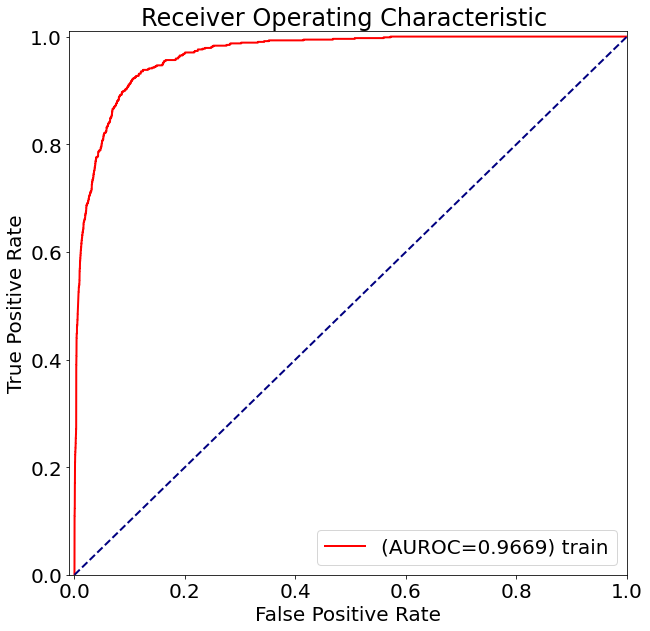

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUPRC Score: 0.735939


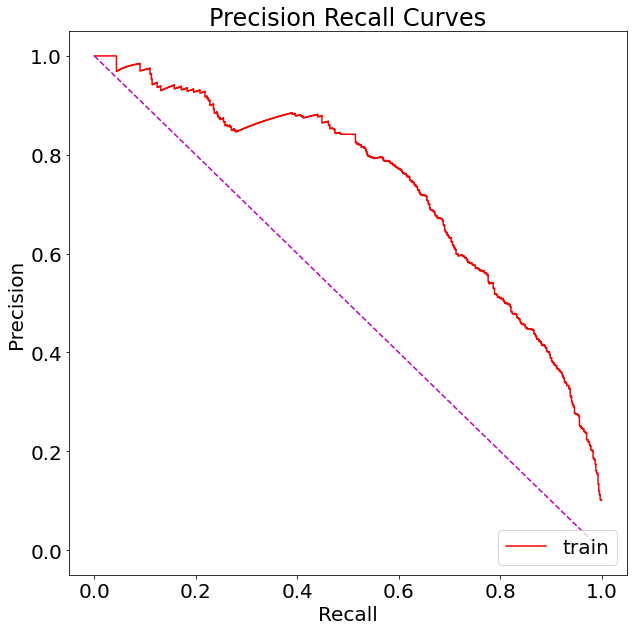

In [12]:
#ROC and PR plot for training
color = ["red"]
path1 = 'Figure_train_origin_RI_ROC.eps'
auroc = ROC([y], [y_predprob0],name = ["train"],color=color,figure=True,path= path1)
path2 = 'Figure_train_origin_RI_PR.eps'
PRC([y], [y_predprob0],name = ["train"],color=color,figure=True,path=path2)
result = pd.DataFrame({"pred": y_pred0,"prob":y_predprob0})
result.to_csv("RI_origin_train_result.csv")

### 5. Independent test(c_2,c_7,c_20,c_34,c_39,c_45,c_51) and the spatial plot for all samples

In [25]:
from bunch import Bunch
sample = ["c_2","c_7","c_20","c_34","c_39","c_45","c_51","c_3","c_4","c_36"]
L_data2 = Bunch()
L_bartls = Bunch()
l_y = []
l_y_pred = []
l_y_predprob = []
check = True
l_check = []
accurancy = []
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#load data
for i in range(len(sample)):
    #load y
    path = 'result/'+sample[i]+'_annotation.csv'
    data = pd.read_csv(path)
    c = data.shape[0]
    #load X
    path = "result/"+sample[i]+"_matrix.csv"
    X_data = pd.read_csv(path)
    l_gene = X_data["Unnamed: 0"]
    for j in intersection:
        if j in l_gene.tolist():
            continue
        else:
            check = False
            break
    l_check.append(check)
    if not check:
        print("not enough gene for sample {}".format(sample[i]))
        continue
    bar = X_data.columns[1:]
    #Adjust the barcode for X
    l_bar=[]
    for j in bar:
        j=str(j).replace("X","")
        l_bar.append(j)
    a = X_data.shape[0]
    b = X_data.shape[1]-1
    X_data = np.array(X_data[bar])
    #normalization
    X_scaler = scaler.fit(X_data)                                   
    X_data = X_scaler.transform(X_data)
    #reconstruct X
    X_data = pd.DataFrame(X_data.T, columns = l_gene, index = l_bar)
    #only retaion the gene in intersection set of the training sample
    X_data = X_data[intersection]
    #adjust the barcode for y
    D1 = dict()
    key = []
    for l in range(c):
        x = '-'+str(i)
        key1 = data['Unnamed: 0'][l]
        value1 = data['TLS_2_cat_annot'][l]
        key1 = str(key1).replace('-1','.1')
        key.append(key1)
        D1[key1] = value1
    L1 = list()
    for j in l_bar:
        if j in key:
            tls = D1[j]
        else:
            tls = 'NO_TLS'
        L1.append(tls)
    print(sample[i])
    #transform to 0,1
    y_data = transformation(L1)
    y_data = y_data.ravel()
    l_y.append(y_data)
    #fit model
    X_data = X_data[intersection]
    y_pred1= svc.predict(X_data)
    y_predprob1= svc.predict_proba(X_data)[:,1]
    l_y_pred.append(y_pred1)
    l_y_predprob.append(y_predprob1)
    print("Testing Accuracy : %.4g" % metrics.accuracy_score(y_data, y_pred1))
    accurancy.append(metrics.accuracy_score(y_data, y_pred1))
    data1 = pd.DataFrame(y_pred1)
    data1 = pd.DataFrame(data1.values, index = l_bar)
    #add position information
    path2 = 'position/'+sample[i]+'_positions_list.csv'
    data2 = pd.read_csv(path2)
    data2 = data2[['barcodes','X','Y']]
    data2 = pd.DataFrame(data2.values.T,index = ['barcodes','X','Y'])
    l_barcodes2 = data2.loc['barcodes'].tolist()
    l_barcodes3=[]
    for k in l_bar:
        index = k.find("_")
        word = k[index+1:]
        word = word.replace(".","-")
        l_barcodes3.append(word)
    data1.index = l_barcodes3
    data2 = pd.DataFrame(data2.values,columns = data2.loc['barcodes'])
    data2.index = ['barcodes','X','Y']
    #connect position and annotation
    D_tls = {}
    for key in l_barcodes3:
        D_tls[key] = data1.loc[key]
    l_bartls = []
    for bar in l_barcodes2:
        if bar in l_barcodes3:
            l_bartls.append(int(D_tls[bar]))
        else:
            l_bartls.append(-1)
    L_data2[sample[i]] = data2
    L_bartls[sample[i]]=l_bartls

c_2
127
Testing Accuracy : 0.9369
c_7
128
Testing Accuracy : 0.9033
c_20
94
Testing Accuracy : 0.9798
c_34
88
Testing Accuracy : 0.3734
c_39
16
Testing Accuracy : 0.9726
c_45
21
Testing Accuracy : 0.9853
c_51
206
Testing Accuracy : 0.9502
c_3
257
Testing Accuracy : 0.898
c_4
199
Testing Accuracy : 0.907
c_36
255
Testing Accuracy : 0.9763


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUROC Score: 0.767340
AUROC Score: 0.872993
AUROC Score: 0.800051
AUROC Score: 0.941802
AUROC Score: 0.797612
AUROC Score: 0.866744
AUROC Score: 0.939518
AUROC Score: 0.947666
AUROC Score: 0.952985
AUROC Score: 0.994233


<Figure size 432x288 with 0 Axes>

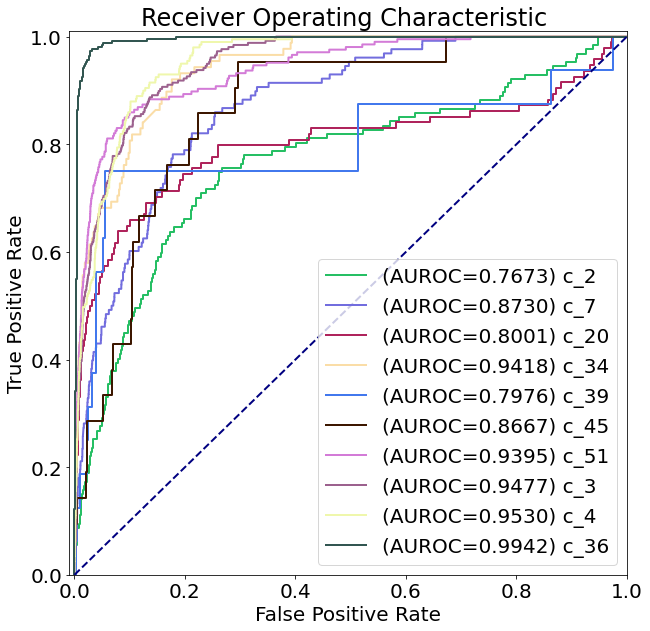

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUPRC Score: 0.144454
AUPRC Score: 0.204073
AUPRC Score: 0.302693
AUPRC Score: 0.435187
AUPRC Score: 0.030770
AUPRC Score: 0.101088
AUPRC Score: 0.591771
AUPRC Score: 0.543800
AUPRC Score: 0.544202
AUPRC Score: 0.931506


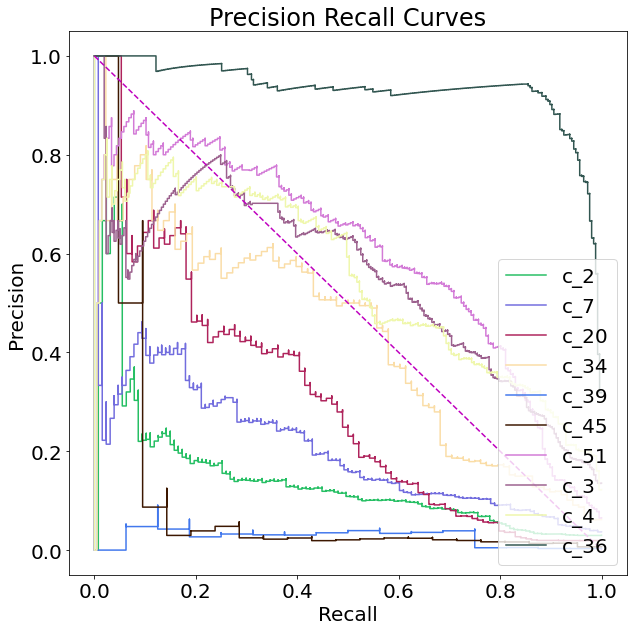

In [26]:
#number = len(l_y)
#color = ColorGenerate(number)
color = ['#26BF64','#726DDE','#AF245C','#FADDA7','#4278ED','#3C1700','#D37BD7','#9C618E','#EFF7AC','#325651']
path1 = 'Figure_test_origin_RI_ROC.eps'
auroc = ROC(l_y, l_y_predprob,name = sample,color=color,figure=True,path= path1)
path2 = 'Figure_test_origin_RI_PR.eps'
PRC(l_y, l_y_predprob,name = sample,color=color,figure=True,path= path2)
df = pd.DataFrame({"sample":sample,"accurancy":accurancy,"auroc":auroc})
df.to_csv("RI_origin_test_performance.csv")

In [27]:
sample = ["c_2","c_7","c_20","c_34","c_39","c_45","c_51","c_3","c_4","c_36"]
for i in range(len(sample)):
    print(sample[i])
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(l_y[i], l_y_pred[i], labels=None, sample_weight=None)
    precision = cm[1,1]/(cm[1,1]+cm[0,1])
    recall = cm[1,1]/(cm[1,0]+cm[1,1])
    print("precision: {}".format(precision))
    print("recall: {}".format(recall))

c_2
precision: 0.15178571428571427
recall: 0.2677165354330709
c_7
precision: 0.14227642276422764
recall: 0.546875
c_20
precision: 0.45614035087719296
recall: 0.2765957446808511
c_34
precision: 0.03914590747330961
recall: 1.0
c_39
precision: 0.03875968992248062
recall: 0.3125
c_45
precision: 0.057692307692307696
recall: 0.14285714285714285
c_51
precision: 0.4840764331210191
recall: 0.7378640776699029
c_3
precision: 0.3256880733944954
recall: 0.8287937743190662
c_4
precision: 0.33814432989690724
recall: 0.8241206030150754
c_36
precision: 0.7915309446254072
recall: 0.9529411764705882


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


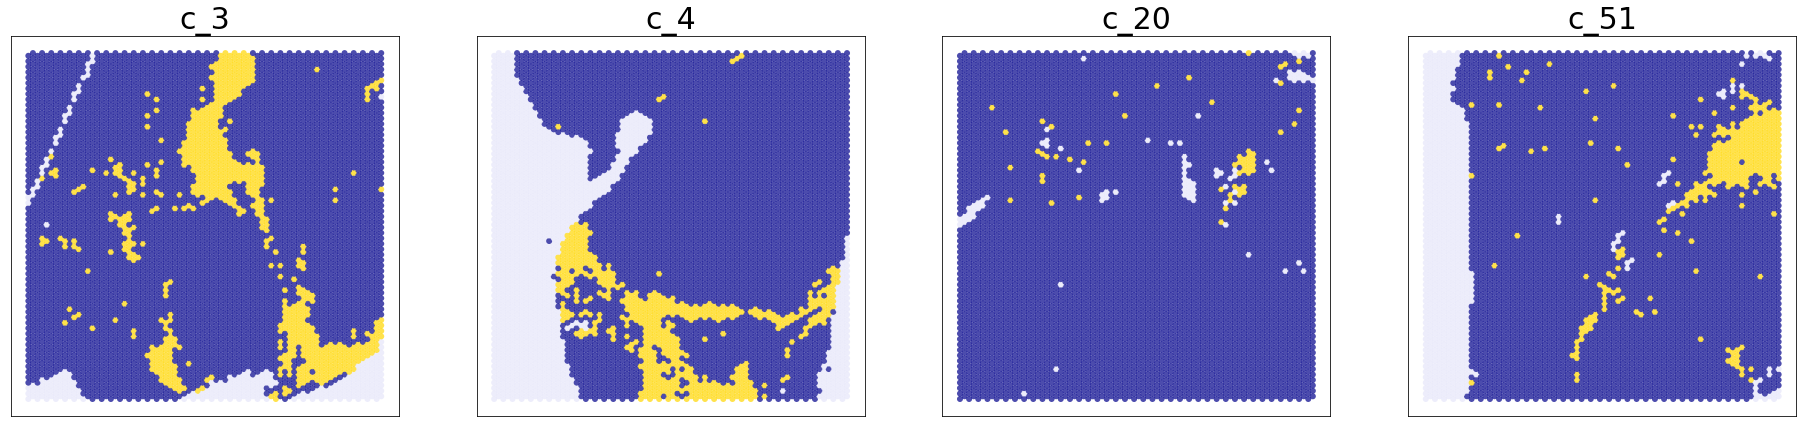

In [28]:
sample = ["c_3","c_4","c_20","c_51"]
fig, ax = plt.subplots(1, 4, figsize=(32,7))
import matplotlib as mpl
cmp = mpl.colors.ListedColormap(['lavender','darkblue','gold'])
norm = mpl.colors.BoundaryNorm([-1,0,1,2], cmp.N)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmp)
for i in range(len(sample)):
    y = i%4
    name = sample[i]
    df=L_data2[name]
    ax[y].set_title(name, fontsize=30)
    ax[y].get_xaxis().set_visible(False)
    ax[y].get_yaxis().set_visible(False)
    ax[y].scatter(np.array(df.loc['X'].tolist()),np.array(df.loc['Y'].tolist()), c=L_bartls[name], edgecolors='none', cmap=cmp, norm=norm,alpha=0.7)
plt.savefig('Figure4A_RI_origin'+'.eps',dpi=600,bbox_inches='tight')#保存文件在指定文件夹下很方便
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


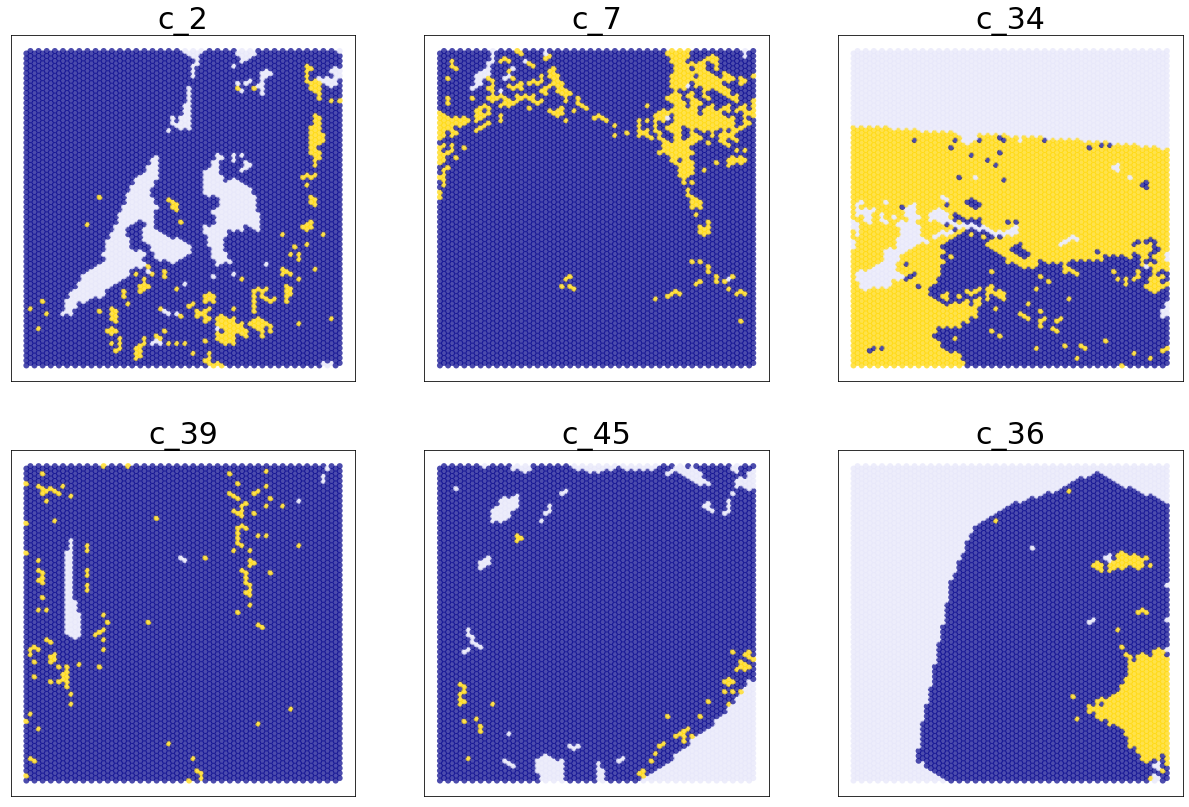

In [29]:
sample = ["c_2","c_7","c_34","c_39","c_45","c_36"]
fig, ax = plt.subplots(2, 3, figsize=(21,14))
import matplotlib as mpl
cmp = mpl.colors.ListedColormap(['lavender','darkblue','gold'])
norm = mpl.colors.BoundaryNorm([-1,0,1,2], cmp.N)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmp)
for i in range(len(sample)):
    x = i//3
    y = i%3
    name = sample[i]
    df=L_data2[name]
    ax[x,y].set_title(name, fontsize=30)
    ax[x,y].get_xaxis().set_visible(False)
    ax[x,y].get_yaxis().set_visible(False)
    ax[x,y].scatter(np.array(df.loc['X'].tolist()),np.array(df.loc['Y'].tolist()), c=L_bartls[name], edgecolors='none', cmap=cmp, norm=norm,alpha=0.7)
plt.savefig('FigureS4A_RI_origin'+'.eps',dpi=600,bbox_inches='tight')
plt.show()